<a href="https://colab.research.google.com/github/dgalassi99/quant-trading-self-study/blob/main/more/Meta_Labelling_%26_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Main Code

This exercise comes from studying "Machine Learning for Asset Managers". Due to the size of the exercise I created a separate notebook file.

The full book study and exercise is here: https://github.com/dgalassi99/quant-trading-self-study/blob/main/00_books/Machine_Learning_for_Asset_Managers.ipynb

 Using the labels generated with the triple-barrier method:
- Fit a random forest classifier on those labels. Use as features estimates of
mean return, volatility, skewness, kurtosis, and various differences in
moving averages.
- Backtest those predictions using as a trading rule the same rule used to
generate the labels.
- Apply meta-labeling on the backtest results.
- Refit the random forest on meta-labels, adding as a feature the label
predicted in (a).
- Size (a) bets according to predictions in (d), and recompute the backtest




## Main Results: Summary

The main results are the following:

*What do we notice?*

- Clearly the strategy is not profitable for this asset and this period
- But adding the meta labelling correction reduces significatively the losses

The losses are reduced by:
- 30% if trading only when the prob of meta label is greater than 50%
- 50 when we correct the bet sizing linearly with the probability of meta labelling
- 75% when we correct quadratically

## Labelling with Triple Barrier Method

In [1]:
from google.colab import drive
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

drive.mount('/content/drive')
# Load the CSV data
file_path = '/content/drive/MyDrive/QUANT/DATA/btc_1h_data_2018_to_2025.csv'
df = pd.read_csv(file_path, date_format='%Y%m%d %H%M%S')
df['Open time'] = pd.to_datetime(df['Open time'])
df = df[['Open time', 'Close','Volume']]

#define a target volume --> we use the average
target_vol = df.Volume.mean()
df['cum_vol'] = df.Volume.cumsum()
#create the bar_num in the df
df['vol_bar_num'] = df.cum_vol.apply(lambda x: x/target_vol).astype(int)
#keep only when vol_bar_num changes
df_vol = df.groupby('vol_bar_num').first()

#compute returns and std
df_vol['returns'] = df_vol.Close.pct_change()
std_returns = df_vol.returns.std()
# horizontal barriers #
hrz_barrier = 2*std_returns
print(f"Standard deviation of returns: {std_returns:.6f}")
print(f"Horizontal barrier (2 * std): {hrz_barrier:.6f}")

''' the maximum holding period is defined as the
average number of bars per day

'''
#reset index to use timestamps again
df_vol = df_vol.reset_index()
#add date column (only the day)
df_vol['date'] = df_vol['Open time'].dt.date
# Count bars per day, then average
bars_per_day = df_vol.groupby('date').size()
max_holding_period = int(bars_per_day.mean())
print(f"Max holding period (avg bars/day): {max_holding_period}")

labels = []  # list to store labels

#loop through the rows, stopping max_holding_period early
for i in range(len(df_vol.Close) - max_holding_period):
    label = 0  # default label
    start_price = df_vol.Close.iloc[i]

    #look forward up to max_holding_period steps
    for j in range(1, max_holding_period + 1):
        future_price = df_vol.Close.iloc[i + j]
        returns = (future_price - start_price) / start_price
        #check labelling conditions
        if returns >= hrz_barrier:
            label = 1
            break
        elif returns <= -hrz_barrier:
            label = -1
            break

    labels.append(label)
#append NaNs to align with df_vol's length
labels += [np.nan] * max_holding_period
df_vol["label"] = labels
print(df_vol['label'].value_counts(dropna=True))


Mounted at /content/drive
Standard deviation of returns: 0.009658
Horizontal barrier (2 * std): 0.019315
Max holding period (avg bars/day): 14
label
 1.0    13132
 0.0    13017
-1.0    12436
Name: count, dtype: int64


In [2]:
# overall distribution
overall_dist = df_vol['label'].value_counts(normalize=True)
print("Overall label distribution (Triple Barrier):")
print(overall_dist)

df_vol['hour'] = df_vol['Open time'].dt.hour
hourly_dist = df_vol.groupby('hour')['label'].value_counts(normalize=True).unstack().fillna(0)
print("Hourly label distribution (Triple Barrier):")
print(hourly_dist)

Overall label distribution (Triple Barrier):
label
 1.0    0.340340
 0.0    0.337359
-1.0    0.322301
Name: proportion, dtype: float64
Hourly label distribution (Triple Barrier):
label      -1.0       0.0       1.0
hour                               
0      0.343131  0.328134  0.328734
1      0.327804  0.332449  0.339748
2      0.330812  0.323934  0.345254
3      0.325747  0.327881  0.346373
4      0.317073  0.335725  0.347202
5      0.313584  0.317919  0.368497
6      0.327610  0.340659  0.331731
7      0.325032  0.332695  0.342273
8      0.324040  0.332714  0.343247
9      0.338054  0.327586  0.334360
10     0.307359  0.333333  0.359307
11     0.319436  0.321888  0.358676
12     0.328054  0.328054  0.343891
13     0.329570  0.318817  0.351613
14     0.330474  0.346115  0.323411
15     0.315628  0.356997  0.327375
16     0.315817  0.356280  0.327903
17     0.305035  0.353630  0.341335
18     0.330055  0.344806  0.325138
19     0.315231  0.347066  0.337703
20     0.311746  0.333333  0.

In [3]:
df = df_vol.copy()
df.head()

,vol_bar_num,Open time,Close,Volume,cum_vol,returns,date,label,hour
0,0,2018-01-01 00:00:00,13529.01,443.356199,443.356199,NaN,2018-01-01,-1.0,0
1,1,2018-01-01 07:00:00,13570.35,292.188777,2978.419643,0.003056,2018-01-01,-1.0,7
2,2,2018-01-01 15:00:00,13247.00,427.071957,6130.108727,-0.023828,2018-01-01,1.0,15
3,3,2018-01-02 00:00:00,13750.01,466.596114,9076.511958,0.037972,2018-01-02,-1.0,0
4,4,2018-01-02 04:00:00,13127.31,992.418927,11967.867697,-0.045287,2018-01-02,1.0,4


## Classification Using a Random Forest Clasifier

- We labeled data based on *actual future price behavior* using the TBM
- Now we build a model able to predict those labels in *real-time* using features known at the current time

It is important to pick the right features in roder to make the prediction using ML methods. So the first step consists in picking some features and check their correlation. Then we can proceed with a tree-based method and also check the feature importance a posteriori to eventually eliminate redundand/overfitting covariates!

In [4]:
df['mean_return_5'] = df['returns'].rolling(window=5).mean()
df['mean_return_10'] = df['returns'].rolling(window=10).mean()
df['volatility_5'] = df['returns'].rolling(window=5).std()
df['volatility_10'] = df['returns'].rolling(window=10).std()
df['skew_5'] = df['returns'].rolling(window=5).skew()
df['skew_10'] = df['returns'].rolling(window=10).skew()
df['kurt_5'] = df['returns'].rolling(window=5).kurt()
df['kurt_10'] = df['returns'].rolling(window=10).kurt()
df['ma_fast'] = df['Close'].rolling(window=5).mean()
df['ma_slow'] = df['Close'].rolling(window=20).mean()
df['ma_diff'] = df['ma_fast'] - df['ma_slow']
df.dropna(inplace=True)
df.head()

,vol_bar_num,Open time,Close,Volume,cum_vol,returns,date,label,hour,mean_return_5,mean_return_10,volatility_5,volatility_10,skew_5,skew_10,kurt_5,kurt_10,ma_fast,ma_slow,ma_diff
19,19,2018-01-04 12:00:00,14398.97,915.408594,55751.072327,0.006991,2018-01-04,1.0,12,-0.005121,-0.002126,0.023558,0.025019,-0.980632,-0.959550,-0.549965,-0.290400,14739.024,14251.9785,487.0455
20,20,2018-01-04 15:00:00,14353.01,1209.805263,58796.494918,-0.003192,2018-01-04,1.0,15,-0.007597,-0.002605,0.022294,0.024986,-0.708680,-0.892010,-0.239961,-0.380600,14624.424,14293.1785,331.2455
21,21,2018-01-04 18:00:00,14811.00,779.049764,61570.903578,0.031909,2018-01-04,1.0,18,-0.004513,0.000288,0.027024,0.027274,0.035120,-0.804996,0.074829,-0.588005,14552.200,14355.2110,196.9890
22,22,2018-01-04 21:00:00,14797.88,707.223774,64268.297104,-0.000886,2018-01-04,1.0,21,-0.001090,-0.002172,0.025951,0.026006,-0.564991,-0.674250,1.775042,-0.451360,14531.974,14432.7550,99.2190
23,23,2018-01-05 01:00:00,15040.00,922.722973,67547.331189,0.016362,2018-01-05,1.0,1,0.010237,0.004173,0.014333,0.021106,0.930646,-0.993132,-0.005398,1.065336,14680.172,14497.2545,182.9175


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

#eventually drop rows with NaNs
df_model = df.dropna(subset=[
    'label', 'returns', 'mean_return_5', 'mean_return_10',
    'volatility_5', 'volatility_10', 'skew_5', 'skew_10',
    'kurt_5', 'kurt_10', 'ma_fast', 'ma_slow', 'ma_diff'
])
#features to regress on
feature_cols = [
    'returns', 'mean_return_5', 'mean_return_10',
    'volatility_5', 'volatility_10', 'skew_5', 'skew_10',
    'kurt_5', 'kurt_10', 'ma_fast', 'ma_slow', 'ma_diff'
]

X = df_model[feature_cols]
y = df_model['label']

#train/test split following the time series ordinality
train_size = int(0.8 * len(X))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

#fit classifier with best estimator evaluated via CV
clf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf = 4, max_features = 'sqrt', class_weight = 'balanced_subsample',random_state=42)
clf.fit(X_train, y_train)

#predict
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

#store predictions
df_model.loc[X_test.index, 'predicted_label'] = y_pred


              precision    recall  f1-score   support

        -1.0       0.36      0.74      0.48      2484
         0.0       0.51      0.33      0.40      2432
         1.0       0.31      0.11      0.16      2798

    accuracy                           0.38      7714
   macro avg       0.39      0.39      0.35      7714
weighted avg       0.39      0.38      0.34      7714



Considering the low qialuty of the metrics we try performing a CV with different hyperparams

In [19]:
# remove comment if you want to run in but the best estimators are calculated once and directly inserted in the cell above!
'''from sklearn.model_selection import RandomizedSearchCV
#defininf the grid of parameeters for cross validation
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

#our metric to maximize is F1
scoring = 'f1_macro'  # gives equal weight to each class

rf = RandomForestClassifier(random_state=42)
search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=50,
    scoring='f1_macro',
    cv=3,
    verbose=2,
    n_jobs=1,
    random_state=42
)

search.fit(X_train, y_train)
best_rf = search.best_estimator_
y_pred = best_rf.predict(X_test)

print(classification_report(y_test, y_pred))
'''

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END class_weight=balanced_subsample, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.3min
[CV] END class_weight=balanced_subsample, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.0min
[CV] END class_weight=balanced_subsample, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.0min
[CV] END class_weight=balanced, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  13.3s
[CV] END class_weight=balanced, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  13.3s
[CV] END class_weight=balanced, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  13.4s
[CV] END class_weight=balanced_subsample, max_d

Even with cross validation the model did not improve significantly - here you can read the best hyperparams!!!

In [20]:
print("Best parameters found:")
print(search.best_params_)

Best parameters found:
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'class_weight': 'balanced_subsample'}


## Backtesting the Predictions

Now we will perform a backtest on the test dataset.

With the following idea:
- if y_pred = 1(-1) --> go long (short)
- if y_pred = 0 --> do nothing

Once a postion is entered...
- TP when the 2sigma barrier is hit that is if P(t+1) = p(t) + 2sigma
- SL when the 2sigma barrier is hit that is if P(t+1) = p(t) - 2sigma

So we have a symmetric risk reward configuration in this case!

In [6]:
df_vol.loc[X_test.index, 'predicted_label'] = y_pred #appending the column of prediction to the data
df_vol.dropna(inplace=True) #remove all teh lines where there is no prediction (training set)

In [7]:
print(hrz_barrier)
print(max_holding_period)

0.01931505532734949
14


In [8]:
#copy df_vol and reset the index to start from 0
df = df_vol.copy()
df.reset_index(drop=True, inplace=True)

In [24]:
#take only the first number_of_bars rows to test the backtesting strategy
number_of_bars = df.shape[0] # at this point we include them all!
df_test = df[:number_of_bars]
df_test.shape

(7714, 10)

In [25]:
#number of observation to loop in considering we are not looping in the last max_holding_period lines
rows_to_iter = len(df_test) - max_holding_period
# define lists to be saved

tp = hrz_barrier
sl = hrz_barrier

#---- to save ----#
results = []

for row in range(rows_to_iter):
  pred_label = df_test.iloc[row]['predicted_label']
  #if the predicted label is 0 we do nothing
  if pred_label == 0.0 or np.isnan(pred_label):
    continue
  #save the entry price before starting the trade
  entry_price = df_test.iloc[row]['Close']
  exit_index = row + max_holding_period  # default vertical barrier
  final_pnl = None

  #now we take the row and loop between row and row+max_holding_period (vertical barrier)
  for period in range(1, max_holding_period+1):
    #calculate return on the next periods
    future_price = df_test.iloc[row+period]['Close']
    ret = (future_price - entry_price) / entry_price

    #if the label is 1 (long) check if we hit TP or SL
    if pred_label == 1:
      #if return hits/goes over the tp append the return in pnl
      if ret >= tp:
        final_pnl = ret
        exit_indices = row+period
        break
      #if return hits/goes under the sl append the return in pnl
      elif ret <= -sl:
        final_pnl = ret
        exit_indices = row+period
        break

    #if the label is -1 (short) check if we hit TP or SL (with inverted signs!!!)
    if pred_label == -1:
      #if return hits/goes over the tp append the return in pnl
      if -ret >= tp:
        final_pnl = -ret
        exit_indices = row+period
        break
      #if return hits/goes under the sl append the return in pnl
      elif -ret <= -sl:
        final_pnl = -ret
        exit_indices = row+period
        break

      #or if none of these the vertical barrier is hit
    if final_pnl is None:
        # if no TP/SL hit, assign pnl at vertical barrier
      final_pnl = (df_test.iloc[exit_index]['Close'] - entry_price) / entry_price
      if pred_label == -1:
          final_pnl = -final_pnl

    results.append({
        'entry_index': row,
        'exit_index': exit_index,
        'pnl': final_pnl
    })

# Create a DataFrame with the trades
bt_df = pd.DataFrame(results)
bt_df['cumulative_pnl'] = bt_df['pnl'].cumsum()

# Merge into df_test
df_test['pnl'] = np.nan
df_test['exit_index'] = np.nan
df_test.loc[bt_df['entry_index'], 'pnl'] = bt_df['pnl'].values
df_test.loc[bt_df['entry_index'], 'exit_index'] = bt_df['exit_index'].values
df_test['cumulative_pnl'] = df_test['pnl'].fillna(0).cumsum()

/tmp/ipython-input-25-89189394.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pnl'] = np.nan
/tmp/ipython-input-25-89189394.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['exit_index'] = np.nan
/tmp/ipython-input-25-89189394.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

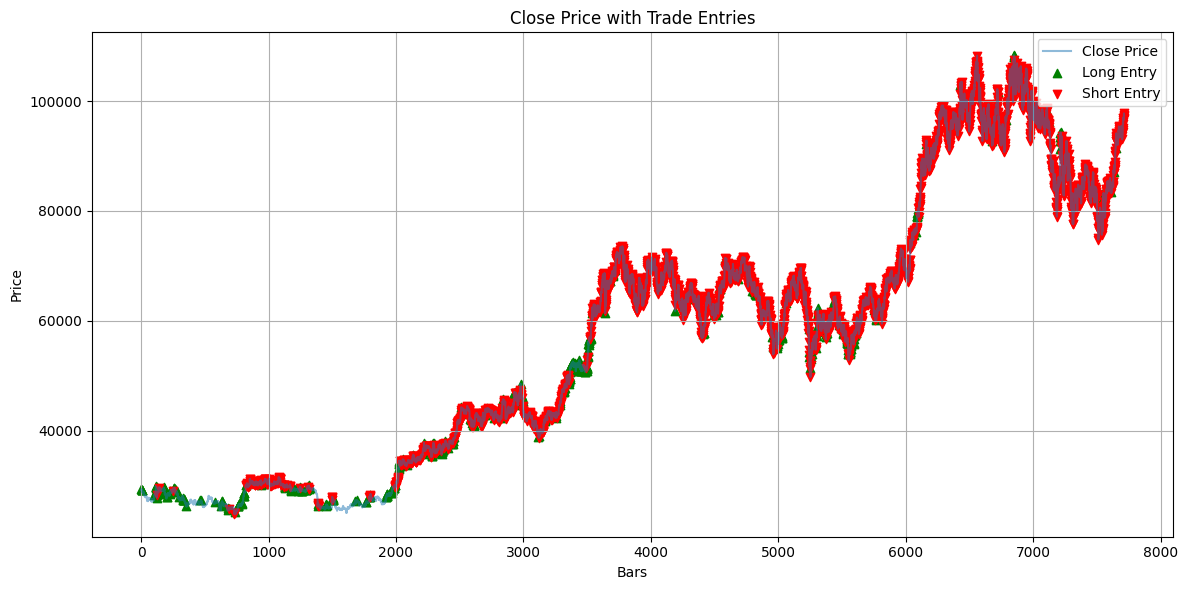

In [26]:
plt.figure(figsize=(12,6))

#close price
plt.plot(df_test.index,df_test['Close'], label='Close Price', alpha=0.5)
#entry points
long_trades = df_test.loc[df_test['predicted_label'] == 1.0]
short_trades = df_test.loc[df_test['predicted_label'] == -1.0]
plt.scatter(long_trades.index, long_trades['Close'], marker='^', color='green', label='Long Entry')
plt.scatter(short_trades.index, short_trades['Close'], marker='v', color='red', label='Short Entry')

plt.title('Close Price with Trade Entries')
plt.xlabel('Bars')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Meta-Labelling

We will filter out all th eobservation where no trade has been initiated (predicted_label == 0) and where trades had a negative pnl

In [30]:
df_meta = df_test[df_test.predicted_label != 0].copy()
df_meta['meta_label'] = (df_meta.pnl > 0).astype(int)
df_meta

,vol_bar_num,Open time,Close,Volume,cum_vol,returns,date,label,hour,predicted_label,pnl,exit_index,cumulative_pnl,meta_label
3,55325,2023-04-19 14:00:00,29393.46,3885.91413,1.604044e+08,0.005982,2023-04-19,-1.0,14,1.0,-0.019285,17.0,-0.019285,0
4,55326,2023-04-19 15:00:00,29260.44,3660.78588,1.604081e+08,-0.004525,2023-04-19,0.0,15,1.0,-0.013480,18.0,-0.032766,0
5,55327,2023-04-19 16:00:00,29315.24,1921.49063,1.604100e+08,0.001873,2023-04-19,-1.0,16,1.0,-0.024155,19.0,-0.056921,0
6,55328,2023-04-19 17:00:00,29318.14,2569.77171,1.604126e+08,0.000099,2023-04-19,-1.0,17,1.0,-0.014501,20.0,-0.071421,0
7,55329,2023-04-19 18:00:00,29277.45,2641.42752,1.604152e+08,-0.001388,2023-04-19,-1.0,18,1.0,-0.015622,21.0,-0.087043,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7709,64228,2025-05-02 01:00:00,96970.40,566.90548,1.862164e+08,0.004632,2025-05-02,-1.0,1,-1.0,NaN,NaN,-12.504906,0
7710,64229,2025-05-02 06:00:00,96715.00,383.92171,1.862188e+08,-0.002634,2025-05-02,-1.0,6,-1.0,NaN,NaN,-12.504906,0
7711,64230,2025-05-02 12:00:00,97182.53,893.40406,1.862225e+08,0.004834,2025-05-02,-1.0,12,-1.0,NaN,NaN,-12.504906,0
7712,64231,2025-05-02 14:00:00,97748.40,2123.65060,1.862257e+08,0.005823,2025-05-02,-1.0,14,-1.0,NaN,NaN,-12.504906,0


## Reclassification Adding Meta-Labelling

In [31]:
#we call again df_meta just df for simplicity
df = df_meta.copy()

In [34]:
df['mean_return_5'] = df['returns'].rolling(window=5).mean()
df['mean_return_10'] = df['returns'].rolling(window=10).mean()
df['volatility_5'] = df['returns'].rolling(window=5).std()
df['volatility_10'] = df['returns'].rolling(window=10).std()
df['skew_5'] = df['returns'].rolling(window=5).skew()
df['skew_10'] = df['returns'].rolling(window=10).skew()
df['kurt_5'] = df['returns'].rolling(window=5).kurt()
df['kurt_10'] = df['returns'].rolling(window=10).kurt()
df['ma_fast'] = df['Close'].rolling(window=5).mean()
df['ma_slow'] = df['Close'].rolling(window=20).mean()
df['ma_diff'] = df['ma_fast'] - df['ma_slow']
df.dropna(inplace=True)

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

meta_features = [
    'mean_return_5', 'mean_return_10',
    'volatility_5', 'volatility_10',
    'skew_5', 'skew_10',
    'kurt_5', 'kurt_10',
    'ma_fast', 'ma_slow', 'ma_diff',
    'predicted_label'  # this is the key addition compraed to the firsst classfier
]

X_meta = df[meta_features]
y_meta = df['meta_label']

#train-test split (time-based split to avoid lookahead bias)
X_meta_train, X_meta_test, y_meta_train, y_meta_test = train_test_split(
    X_meta, y_meta, shuffle=False, test_size=0.3
)

#train the meta-model
meta_model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf = 4,random_state=42)
meta_model.fit(X_meta_train, y_meta_train)

#evaluate
y_meta_pred = meta_model.predict(X_meta_test)
print(classification_report(y_meta_test, y_meta_pred))

              precision    recall  f1-score   support

           0       0.75      0.05      0.10       975
           1       0.45      0.98      0.62       786

    accuracy                           0.47      1761
   macro avg       0.60      0.52      0.36      1761
weighted avg       0.62      0.47      0.33      1761



Meta-labeling simplifies the problem to binary classification, focusing on profitable vs. no-profit trades.

The meta-labeling model dramatically improves recall on profitable trades (class 1), which is crucial for trading.

However, it suffers from very low recall on the no-profit class (class 0), meaning it often misses identifying when not to trade.

Accuracy improves from 38% to 47%, which is meaningful but still leaves room for improvement.

Overall F1 scores remain modest, showing this is a challenging prediction problem.

### Backtest with Bet Sizing

df_test.columns

In [40]:
print(X_meta_test.shape)

(1761, 12)


In [48]:
df_meta_test_subset = df_meta.loc[X_meta_test.index]
df_meta_test_subset

,vol_bar_num,Open time,Close,Volume,cum_vol,returns,date,label,hour,predicted_label,pnl,exit_index,cumulative_pnl,meta_label
5839,62106,2024-10-14 15:00:00,65870.00,2620.60347,1.800648e+08,-0.000789,2024-10-14,1.0,15,-1.0,-0.008532,5853.0,-4.458589,0
5840,62107,2024-10-14 16:00:00,65703.99,2115.94718,1.800669e+08,-0.002520,2024-10-14,1.0,16,-1.0,-0.017808,5854.0,-4.476397,0
5841,62108,2024-10-14 19:00:00,65939.40,1385.23734,1.800704e+08,0.003583,2024-10-14,1.0,19,-1.0,-0.016084,5855.0,-4.492481,0
5842,62109,2024-10-14 22:00:00,66454.00,1948.67266,1.800733e+08,0.007804,2024-10-14,0.0,22,-1.0,-0.007803,5856.0,-4.500284,0
5843,62110,2024-10-15 00:00:00,65929.99,1154.23779,1.800754e+08,-0.007885,2024-10-15,1.0,0,-1.0,-0.027356,5857.0,-4.527639,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7694,64213,2025-04-29 18:00:00,95391.29,703.13824,1.861725e+08,0.005780,2025-04-29,-1.0,18,-1.0,-0.011867,7708.0,-12.368502,0
7695,64214,2025-04-29 23:00:00,94256.82,1020.00752,1.861761e+08,-0.011893,2025-04-29,1.0,23,-1.0,-0.028789,7709.0,-12.397291,0
7696,64215,2025-04-30 04:00:00,95054.75,666.14870,1.861786e+08,0.008465,2025-04-30,-1.0,4,-1.0,-0.017466,7710.0,-12.414757,0
7698,64217,2025-04-30 13:00:00,93032.58,2712.01725,1.861858e+08,-0.022527,2025-04-30,1.0,13,-1.0,-0.050690,7712.0,-12.465447,0


In [58]:
#take only the first number_of_bars rows to test the backtesting strategy
number_of_bars = df.shape[0] # at this point we include them all!
df_test = df[:number_of_bars]

#copy df_vol and reset the index to start from 0
df = df_vol.copy()
df.reset_index(drop=True, inplace=True)

#take only the first number_of_bars rows to test the backtesting strategy
number_of_bars = df.shape[0] # at this point we include them all!
df_test = df[:number_of_bars]

#number of observation to loop in considering we are not looping in the last max_holding_period lines
rows_to_iter = len(df_test) - max_holding_period
# define lists to be saved

tp = hrz_barrier
sl = hrz_barrier

#---- to save ----#
results = []

for row in range(rows_to_iter):
  pred_label = df_test.iloc[row]['predicted_label']
  #if the predicted label is 0 we do nothing
  if pred_label == 0.0 or np.isnan(pred_label):
    continue
  #save the entry price before starting the trade
  entry_price = df_test.iloc[row]['Close']
  exit_index = row + max_holding_period  # default vertical barrier
  final_pnl = None

  #now we take the row and loop between row and row+max_holding_period (vertical barrier)
  for period in range(1, max_holding_period+1):
    #calculate return on the next periods
    future_price = df_test.iloc[row+period]['Close']
    ret = (future_price - entry_price) / entry_price

    #if the label is 1 (long) check if we hit TP or SL
    if pred_label == 1:
      #if return hits/goes over the tp append the return in pnl
      if ret >= tp:
        final_pnl = ret
        exit_indices = row+period
        break
      #if return hits/goes under the sl append the return in pnl
      elif ret <= -sl:
        final_pnl = ret
        exit_indices = row+period
        break

    #if the label is -1 (short) check if we hit TP or SL (with inverted signs!!!)
    if pred_label == -1:
      #if return hits/goes over the tp append the return in pnl
      if -ret >= tp:
        final_pnl = -ret
        exit_indices = row+period
        break
      #if return hits/goes under the sl append the return in pnl
      elif -ret <= -sl:
        final_pnl = -ret
        exit_indices = row+period
        break

      #or if none of these the vertical barrier is hit
    if final_pnl is None:
        # if no TP/SL hit, assign pnl at vertical barrier
      final_pnl = (df_test.iloc[exit_index]['Close'] - entry_price) / entry_price
      if pred_label == -1:
          final_pnl = -final_pnl

    results.append({
        'entry_index': row,
        'exit_index': exit_index,
        'pnl': final_pnl
    })

# Create a DataFrame with the trades
bt_df = pd.DataFrame(results)
bt_df['cumulative_pnl'] = bt_df['pnl'].cumsum()

# Merge into df_test
df_test['pnl'] = np.nan
df_test['exit_index'] = np.nan
df_test.loc[bt_df['entry_index'], 'pnl'] = bt_df['pnl'].values
df_test.loc[bt_df['entry_index'], 'exit_index'] = bt_df['exit_index'].values
df_test['cumulative_pnl'] = df_test['pnl'].fillna(0).cumsum()

# Recreate df_meta_test_subset to ensure it has the 'cumulative_pnl' column before dropping
df_meta_test_subset = df_meta.loc[X_meta_test.index].copy()
df_meta_test_subset.drop('cumulative_pnl', axis=1, inplace=True)

,vol_bar_num,Open time,Close,Volume,cum_vol,returns,date,label,hour,predicted_label,pnl,exit_index,meta_label,bet_size,pnl_sized,cumulative_pnl_sized,bet_size_2,pnl_sized_2,cumulative_pnl_sized_2
5839,62106,2024-10-14 15:00:00,65870.00,2620.60347,1.800648e+08,-0.000789,2024-10-14,1.0,15,-1.0,-0.008532,5853.0,0,0.458567,-0.003912,-0.003912,0.0,-0.000000,-0.000000
5840,62107,2024-10-14 16:00:00,65703.99,2115.94718,1.800669e+08,-0.002520,2024-10-14,1.0,16,-1.0,-0.017808,5854.0,0,0.542849,-0.009667,-0.013579,1.0,-0.017808,-0.017808
5841,62108,2024-10-14 19:00:00,65939.40,1385.23734,1.800704e+08,0.003583,2024-10-14,1.0,19,-1.0,-0.016084,5855.0,0,0.558604,-0.008985,-0.022564,1.0,-0.016084,-0.033892
5842,62109,2024-10-14 22:00:00,66454.00,1948.67266,1.800733e+08,0.007804,2024-10-14,0.0,22,-1.0,-0.007803,5856.0,0,0.541171,-0.004223,-0.026787,1.0,-0.007803,-0.041695
5843,62110,2024-10-15 00:00:00,65929.99,1154.23779,1.800754e+08,-0.007885,2024-10-15,1.0,0,-1.0,-0.027356,5857.0,0,0.501938,-0.013731,-0.040518,1.0,-0.027356,-0.069051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7694,64213,2025-04-29 18:00:00,95391.29,703.13824,1.861725e+08,0.005780,2025-04-29,-1.0,18,-1.0,-0.011867,7708.0,0,0.719625,-0.008540,-4.787982,1.0,-0.011867,-6.547873
7695,64214,2025-04-29 23:00:00,94256.82,1020.00752,1.861761e+08,-0.011893,2025-04-29,1.0,23,-1.0,-0.028789,7709.0,0,0.739202,-0.021281,-4.809263,1.0,-0.028789,-6.576662
7696,64215,2025-04-30 04:00:00,95054.75,666.14870,1.861786e+08,0.008465,2025-04-30,-1.0,4,-1.0,-0.017466,7710.0,0,0.670377,-0.011709,-4.820972,1.0,-0.017466,-6.594128
7698,64217,2025-04-30 13:00:00,93032.58,2712.01725,1.861858e+08,-0.022527,2025-04-30,1.0,13,-1.0,-0.050690,7712.0,0,0.587867,-0.029799,-4.850771,1.0,-0.050690,-6.644818


In [63]:

#predicted positive class probability
y_meta_pred_proba = meta_model.predict_proba(X_meta_test)[:, 1]
#recalculate the cumulative pnl to start form 0
df_meta_test_subset['cumulative_pnl']= df_meta_test_subset['pnl'].cumsum()
#add those prob to the dataframe
df_meta_test_subset['bet_size'] = y_meta_pred_proba
#add another column to rescale the pnl accordingly to th epredicted probability
#this means that if the prob is alpha % we allocate alpha% of the capital on that trade
#thus the pnl is reflected and rescaled by alpha%

df_meta_test_subset['pnl_sized'] = df_meta_test_subset['pnl'] * df_meta_test_subset['bet_size'] #linear scale by alpha %
df_meta_test_subset['cumulative_pnl_sized'] = df_meta_test_subset['pnl_sized'].cumsum()

# or for example trading only if porb >50 %
df_meta_test_subset['bet_size_2'] = (y_meta_pred_proba > 0.5).astype(float) #--> or for example only trade if the porb is higher than 50%
df_meta_test_subset['pnl_sized_2'] = df_meta_test_subset['pnl'] * df_meta_test_subset['bet_size_2'] #linear scale by alpha %
df_meta_test_subset['cumulative_pnl_sized_2'] = df_meta_test_subset['pnl_sized_2'].cumsum()

#squared correction
df_meta_test_subset['pnl_sized_sq'] = df_meta_test_subset['pnl'] * df_meta_test_subset['bet_size']*df_meta_test_subset['bet_size'] #linear scale by alpha %
df_meta_test_subset['cumulative_pnl_sized_sq'] = df_meta_test_subset['pnl_sized_sq'].cumsum()


In [64]:
df_meta_test_subset

,vol_bar_num,Open time,Close,Volume,cum_vol,returns,date,label,hour,predicted_label,...,cumulative_pnl,meta_label,bet_size,pnl_sized,cumulative_pnl_sized,bet_size_2,pnl_sized_2,cumulative_pnl_sized_2,pnl_sized_sq,cumulative_pnl_sized_sq
5839,62106,2024-10-14 15:00:00,65870.00,2620.60347,1.800648e+08,-0.000789,2024-10-14,1.0,15,-1.0,...,-0.008532,0,0.458567,-0.003912,-0.003912,0.0,-0.000000,-0.000000,-0.001794,-0.001794
5840,62107,2024-10-14 16:00:00,65703.99,2115.94718,1.800669e+08,-0.002520,2024-10-14,1.0,16,-1.0,...,-0.026340,0,0.542849,-0.009667,-0.013579,1.0,-0.017808,-0.017808,-0.005248,-0.007042
5841,62108,2024-10-14 19:00:00,65939.40,1385.23734,1.800704e+08,0.003583,2024-10-14,1.0,19,-1.0,...,-0.042424,0,0.558604,-0.008985,-0.022564,1.0,-0.016084,-0.033892,-0.005019,-0.012061
5842,62109,2024-10-14 22:00:00,66454.00,1948.67266,1.800733e+08,0.007804,2024-10-14,0.0,22,-1.0,...,-0.050227,0,0.541171,-0.004223,-0.026787,1.0,-0.007803,-0.041695,-0.002285,-0.014346
5843,62110,2024-10-15 00:00:00,65929.99,1154.23779,1.800754e+08,-0.007885,2024-10-15,1.0,0,-1.0,...,-0.077583,0,0.501938,-0.013731,-0.040518,1.0,-0.027356,-0.069051,-0.006892,-0.021238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7694,64213,2025-04-29 18:00:00,95391.29,703.13824,1.861725e+08,0.005780,2025-04-29,-1.0,18,-1.0,...,-7.918445,0,0.719625,-0.008540,-4.787982,1.0,-0.011867,-6.547873,-0.006145,-2.973611
7695,64214,2025-04-29 23:00:00,94256.82,1020.00752,1.861761e+08,-0.011893,2025-04-29,1.0,23,-1.0,...,-7.947234,0,0.739202,-0.021281,-4.809263,1.0,-0.028789,-6.576662,-0.015731,-2.989342
7696,64215,2025-04-30 04:00:00,95054.75,666.14870,1.861786e+08,0.008465,2025-04-30,-1.0,4,-1.0,...,-7.964701,0,0.670377,-0.011709,-4.820972,1.0,-0.017466,-6.594128,-0.007849,-2.997191
7698,64217,2025-04-30 13:00:00,93032.58,2712.01725,1.861858e+08,-0.022527,2025-04-30,1.0,13,-1.0,...,-8.015391,0,0.587867,-0.029799,-4.850771,1.0,-0.050690,-6.644818,-0.017518,-3.014709


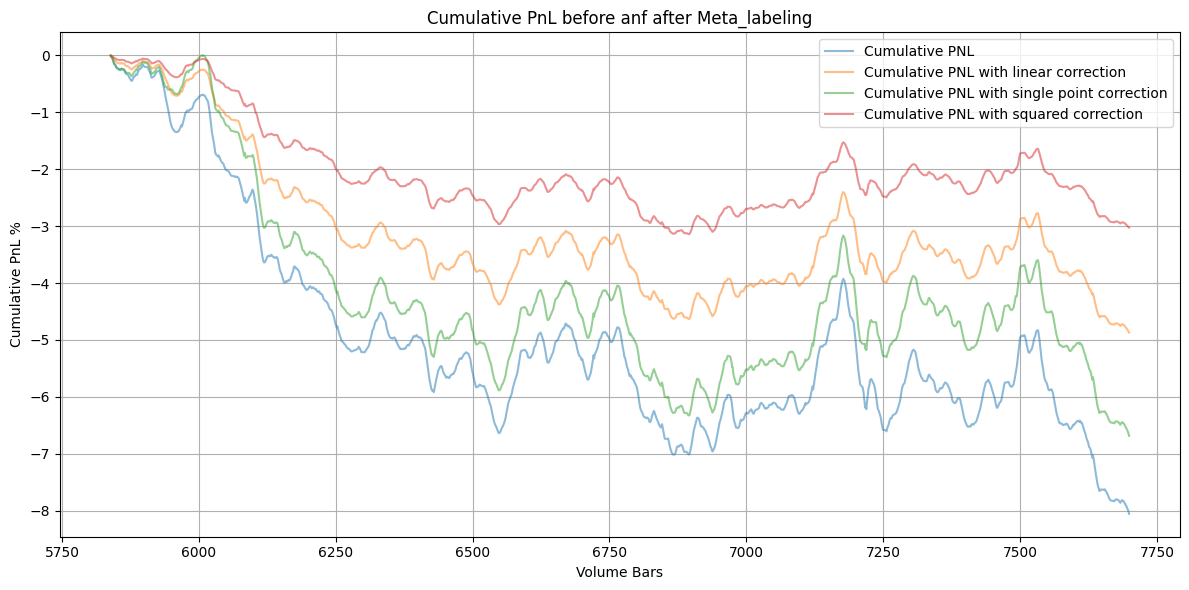

In [65]:
plt.figure(figsize=(12,6))

#close price
plt.plot(df_meta_test_subset.index,df_meta_test_subset['cumulative_pnl'], label='Cumulative PNL', alpha=0.5)
plt.plot(df_meta_test_subset.index,df_meta_test_subset['cumulative_pnl_sized'], label='Cumulative PNL with linear correction', alpha=0.5)
plt.plot(df_meta_test_subset.index,df_meta_test_subset['cumulative_pnl_sized_2'], label='Cumulative PNL with single point correction', alpha=0.5)
plt.plot(df_meta_test_subset.index,df_meta_test_subset['cumulative_pnl_sized_sq'], label='Cumulative PNL with squared correction', alpha=0.5)
plt.title('Cumulative PnL before anf after Meta_labeling')
plt.xlabel('Volume Bars')
plt.ylabel('Cumulative PnL %')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

*What do we notice?*

- Clearly the strategy is not profitable for this asset and this period
- But adding the meta labelling correction reduces significatively the losses

The losses are reduced by:
- 30% if trading only when the prob of meta label is greater than 50%
- 50 when we correct the bet sizing linearly with the probability of meta labelling
- 75% when we correct quadratically